In [2]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake\
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: no se puede crear el directorio «build»: El archivo ya existe
-- The C compiler identification is GNU 4.8.5
-- The CXX compiler identification is GNU 4.8.5
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
Release mode
-- Found PythonInterp: /home/alicia/.pyenv/versions/3.6.5/bin/python (found version "3.6.5") 
-- Found PythonLibs: /home/alicia/.pyenv/versions/3.6.5/lib/libpython3.6m.a
-- pybind11 v2.3.dev0
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/alicia/Documentos/Metodos Numericos/TP3/metodos-tp3
-- Configuring done
-- Generating done
-- Build files have been written to: /home/alicia/Documentos/Metodos Numericos/

In [2]:
import linearregression
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import time
import math
import calendar
import datetime
import matplotlib.dates as mdates
import sys
import pickle

In [3]:
def outliers_cuartil(df):
    q1 = df["Delay"].quantile(0.25)
    q3 = df["Delay"].quantile(0.75)
    d = q3-q1
    df = df[df.Delay > q1- d*1.5]
    df = df[df.Delay < q3 +d*1.5]
    return df

In [4]:
def cross_validation(df,label_x,label_y,particiones,funcion,grado):
    particion_anterior = 0
    diferencias = []
    tam_particion = int(df[label_x].count()/particiones)
    for i in range(particiones):
        if i != particiones-1:
            particion = int(df[label_x].count()/particiones)*(i+1)
            #data_train  = df[label_x][:particion]
            data_train = df.index[:particion]
            #data_test   = df[label_x][particion:particion+tam_particion]
            data_test   = df.index[particion:particion+tam_particion]
            label_train = df[label_y][:particion]
            label_test  = df[label_y][particion:particion+tam_particion]
            particion_anterior = particion
            tp3 = linearregression.CuadradosMinimos(funcion)
            tp3.fit(grado, data_train, label_train)
            ys = tp3.predict(data_test)            
            diferencias.append(sum((ys-label_test)**2))
        #el ultimo se tiene que descartar porque por como agarro las particiones la ultima se compararia a si
        #misma ABS
    RMSE = (sum(diferencias)/(particiones-1))**(1./2)
    return RMSE

In [5]:
def cross_validation_fusion(df,label_x,label_y,particiones,funcion,grado,pi):
    particion_anterior = 0
    diferencias = []
    tam_particion = int(df[label_x].count()/particiones)
    for i in range(particiones):
        if i != particiones-1:
            particion = int(df[label_x].count()/particiones)*(i+1)
            #data_train  = df[label_x][:particion]
            data_train = df.index[:particion]
            #data_test   = df[label_x][particion:particion+tam_particion]
            data_test   = df.index[particion:particion+tam_particion]
            label_train = df[label_y][:particion]
            label_test  = df[label_y][particion:particion+tam_particion]
            particion_anterior = particion
            tp3 = linearregression.CuadradosMinimos(funcion)
            tp3.fit_fusion(grado,pi, data_train, label_train)
            ys = tp3.predict(data_test)            
            diferencias.append(sum((ys-label_test)**2))
        #el ultimo se tiene que descartar porque por como agarro las particiones la ultima se compararia a si
        #misma ABS
    RMSE = (sum(diferencias)/(particiones-1))**(1./2)
    return RMSE

In [100]:
# Graficos los datos reales para tenerlos como referencia

def entrenar_y_predecir_en_rangos(df,rango_entrenamiento, rango_prediccion,familia):
    #yolo
    particiones = 3
    if familia != 'fusion':
        regr = linearregression.CuadradosMinimos(familia)
        df_entrenamiento = df[df.index.isin(rango_entrenamiento)]    
        xi =df_entrenamiento.index.values.astype(float)
        # 'Fiteo' los datos de entrenamiento
        grado = 0
        min_rmse = cross_validation(df,'Date','Delay',particiones,familia,grado)
        mejor_grado = 0
        if familia == 'pol':
            while grado <= 20:
                rmse = cross_validation(df,'Date','Delay',particiones,familia,grado)
                grado += 1
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado
            print(mejor_grado, min_rmse)
        else:
            while grado < 2:
                rmse = cross_validation(df,'Date','Delay',particiones,familia,grado*math.pi)
                grado += 0.01                
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado*math.pi
            print(mejor_grado/math.pi, min_rmse)
        regr.fit(mejor_grado,xi, df_entrenamiento['Delay'])
        df_entrenamiento['pred'] = regr.predict(xi)
        ax.plot(df_entrenamiento.index.values, df_entrenamiento['pred'],'r-')
        ## Realizo predicciones
        df_prediccion = df[df.index.isin(rango_prediccion)]
        xs = df_prediccion.index.values.astype(float)
        # Predigo los datos de testeo
        df_prediccion['pred'] = regr.predict(xs)
        # Grafico la prediccion
        ax.plot(df_prediccion.index.values, df_prediccion['pred'], 'g-')

        ## Calculo el Error Cuadrático Mediodf_prediccion['y'
        ECM = ((df_prediccion['pred'] - df_prediccion['Delay'])**2).mean()    
        return ECM
    else:
        regr = linearregression.CuadradosMinimos(familia)
        df_entrenamiento = df[df.index.isin(rango_entrenamiento)]    
        xi =df_entrenamiento.index.values.astype(float)
        # 'Fiteo' los datos de entrenamiento
        grado = 0
        pi = 0
        min_rmse = cross_validation_fusion(df,'Date','Delay',particiones,familia,grado,pi*math.pi)
        mejor_grado = 0
        mejor_pi = 0
        while grado <= 20:
            pi = 0
            while pi < 2:
                rmse = cross_validation_fusion(df,'Date','Delay',particiones,familia,grado,pi*math.pi)
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado
                    mejor_pi = pi
                pi += 0.01
            grado +=1
        print(mejor_grado,mejor_pi, min_rmse)
        regr.fit_fusion(mejor_grado,mejor_pi*math.pi,xi, df_entrenamiento['Delay'])
        df_entrenamiento['pred'] = regr.predict(xi)
        ax.plot(df_entrenamiento.index.values, df_entrenamiento['pred'],'r-')        
        ## Realizo predicciones
        df_prediccion = df[df.index.isin(rango_prediccion)]
        xs = df_prediccion.index.values.astype(float)
        # Predigo los datos de testeo
        df_prediccion['pred'] = regr.predict(xs)
        # Grafico la prediccion
        ax.plot(df_prediccion.index.values, df_prediccion['pred'], 'g-')        
        ## Calculo el Error Cuadrático Mediodf_prediccion['y'
        ECM = ((df_prediccion['pred'] - df_prediccion['Delay'])**2).mean()    
        return ECM
        

def predecir(k,familia):
    df["IndexDates"] = df["Date"]
    df.IndexDates = pd.to_datetime(df.IndexDates)
    df.index= df["IndexDates"]    
    rango_entrenamiento =(df.index[0:k] )    
    rango_prediccion = (df.index[k:k+(12*2)] )    
    return entrenar_y_predecir_en_rangos(df,  rango_entrenamiento, rango_prediccion,familia)

In [39]:
df = pd.read_csv('CancellationCodexMes2004-2008.csv')
df.Date = pd.to_datetime(df.Date)
df = df[((df.Date.dt.month >= 1) & (df.Date.dt.month <=3 ))] 

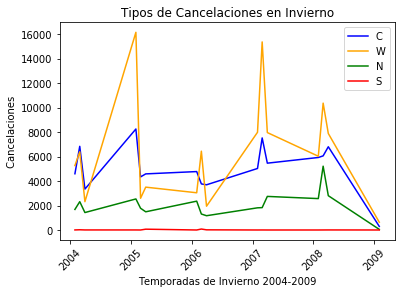

In [40]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
fig, ax= plt.subplots()
ax.plot(df.index.values, 
        df['Cancelled_A'], 
        color = 'blue')
ax.plot(df.index.values, 
        df['Cancelled_B'], 
        color = 'orange')
ax.plot(df.index.values, 
        df['Cancelled_C'], 
        color = 'green')
ax.plot(df.index.values, 
        df['Cancelled_D'], 
        color = 'red')
ax.legend('CWNS')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(xlabel="Temporadas de Invierno 2004-2009",
       ylabel=" Cancelaciones ",
       title="Tipos de Cancelaciones en Invierno");
plt.savefig("images/CancelacionesInvierno.png",bbox_inches = "tight" )

In [44]:
df = pd.read_csv('CancellationCodexMes2004-2008.csv')
df.Date = pd.to_datetime(df.Date)
df = df[((df.Date.dt.month >= 7) & (df.Date.dt.month <=9 ))] 


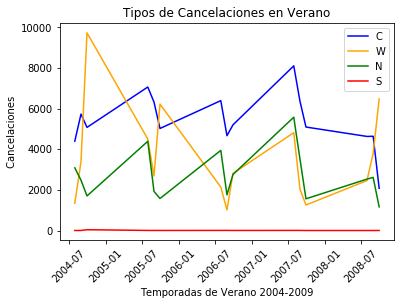

In [45]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
fig, ax= plt.subplots()
ax.plot(df.index.values, 
        df['Cancelled_A'], 
        color = 'blue')
ax.plot(df.index.values, 
        df['Cancelled_B'], 
        color = 'orange')
ax.plot(df.index.values, 
        df['Cancelled_C'], 
        color = 'green')
ax.plot(df.index.values, 
        df['Cancelled_D'],        
        color = 'red')

ax.legend('CWNS')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(xlabel="Temporadas de Verano 2004-2009",
       ylabel=" Cancelaciones ",
       title="Tipos de Cancelaciones en Verano");
plt.savefig("images/CancelacionesVerano.png",bbox_inches = "tight" )

In [209]:
df = pd.read_csv('CancellationCodexMes2004-2008.csv')
df.Date = pd.to_datetime(df.Date)
df = df[((df.Date.dt.month >= 10) & (df.Date.dt.month <=12 ))] 

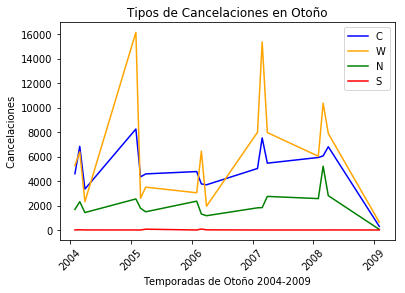

In [42]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
fig, ax= plt.subplots()
ax.plot(df.index.values, 
        df['Cancelled_A'], 
        color = 'blue')
ax.plot(df.index.values, 
        df['Cancelled_B'], 
        color = 'orange')
ax.plot(df.index.values, 
        df['Cancelled_C'], 
        color = 'green')
ax.plot(df.index.values, 
        df['Cancelled_D'],        
        color = 'red')
ax.legend('CWNS')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(xlabel="Temporadas de Otoño 2004-2009",
       ylabel=" Cancelaciones ",
       title="Tipos de Cancelaciones en Otoño");
plt.savefig("images/CancelacionesOtoño.png",bbox_inches = "tight" )

In [211]:
df = pd.read_csv('CancellationCodexMes2004-2008.csv')
df.Date = pd.to_datetime(df.Date)
df = df[((df.Date.dt.month >= 4) & (df.Date.dt.month <=6 ))] 


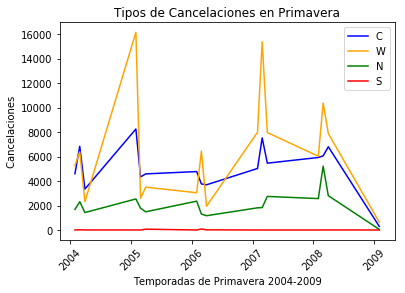

In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
fig, ax= plt.subplots()
ax.plot(df.index.values, 
        df['Cancelled_A'], 
        color = 'blue')
ax.plot(df.index.values, 
        df['Cancelled_B'], 
        color = 'orange')
ax.plot(df.index.values, 
        df['Cancelled_C'], 
        color = 'green')
ax.plot(df.index.values, 
        df['Cancelled_D'],        
        color = 'red')
ax.legend('CWNS')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(xlabel="Temporadas de Primavera 2004-2009",
       ylabel=" Cancelaciones ",
       title="Tipos de Cancelaciones en Primavera");
plt.savefig("images/CancelacionesPrimavera.png",bbox_inches = "tight" )

En invierno se producen los picos de clima + importantes, pero los hay durante todo el año-se comportan mejor en primavera. Las cancelaciones en primavera de Carrier son bastante estables. (pero tienen picos de descenso)  

Veamos que las de carrier en primavera son estables -> debería poder predecir el comportamiento de la proxima primavera usando como base 2 anteriores


0 1.5500000000000012 573.2474425291466
Error de predicción: 16515.01


/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


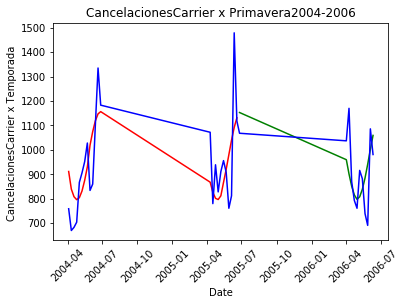

DatetimeIndex(['2004-04-04', '2004-04-11', '2004-04-18', '2004-04-25',
               '2004-05-02', '2004-05-09', '2004-05-16', '2004-05-23',
               '2004-05-30', '2004-06-06', '2004-06-13', '2004-06-20',
               '2004-06-27', '2005-04-10', '2005-04-17', '2005-04-24',
               '2005-05-01', '2005-05-08', '2005-05-15', '2005-05-22',
               '2005-05-29', '2005-06-05', '2005-06-12', '2005-06-19',
               '2005-06-26', '2006-04-02', '2006-04-09', '2006-04-16',
               '2006-04-23', '2006-04-30', '2006-05-07', '2006-05-14',
               '2006-05-21', '2006-05-28', '2006-06-04', '2006-06-11'],
              dtype='datetime64[ns]', name='IndexDates', freq=None)

In [68]:
df = pd.read_csv('CancellationCodexSemana2004-2008.csv')
df.Date = pd.to_datetime(df.Date)
df = df[((df.Date.dt.month >= 4) & (df.Date.dt.month <=6 ))] 
df['Delay'] = df['Cancelled_A']
df = outliers_cuartil(df)
df = df[0:3*12] #3 Temporadas 
fig, ax= plt.subplots()
ECM = predecir(12*2, 'fusion')
#df.set_index('Date')
print("Error de predicción: {:.2f}".format(ECM))

# add the x-axis ad the y-axis to the plot
ax.plot(df.index, 
        df['Delay'], 
        color = 'blue')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)
ax.plot(use_index=False)
# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="CancelacionesCarrier x Temporada ",
       title="CancelacionesCarrier x Primavera2004-2006");
#plt.savefig("CancellationxMonths1988-2008PredFusion1.png")
plt.show()


In [ ]:
Aunque parecía que era estable, los picos hacia abajo cada vez + pronunciados nos son un problema, para ver los picos altos.

In [ ]:
Como los mayores picos se producen en invierno, deberíamos poder, usando las cancelaciones de primavera, verano, ver las de otoño:


0 1.2100000000000009 836.4080995308032
Error de predicción: 44654.19


/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


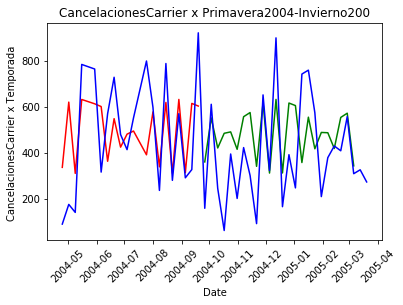

In [73]:
df = pd.read_csv('CancellationCodexSemana2004-2008.csv')
df.Date = pd.to_datetime(df.Date)
df['Delay'] = df['Cancelled_C']
df = df[4*4:4*16] #3 Temporadas 
df = outliers_cuartil(df)
fig, ax= plt.subplots()
ECM = predecir(4*5, 'fusion')
#df.set_index('Date')
print("Error de predicción: {:.2f}".format(ECM))

# add the x-axis ad the y-axis to the plot
ax.plot(df.index.values, 
        df['Delay'], 
        color = 'blue')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="CancelacionesCarrier x Temporada ",
       title="CancelacionesCarrier x Primavera2004-Invierno200");
#plt.savefig("CancellationxMonths1988-2008PredFusion1.png")
plt.show()


(Vemos que hay un pico en invierno, todas las cancelaciones parecen tener picos al principip del invierno (las de clima son las mas significativas))

In [ ]:
EL delay de NAS parece tener una repetición cada temporada de verano, vemos si podemos predecir con eso:

0 0.9300000000000006 1469.1321907825302
Error de predicción: 90953.01


/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


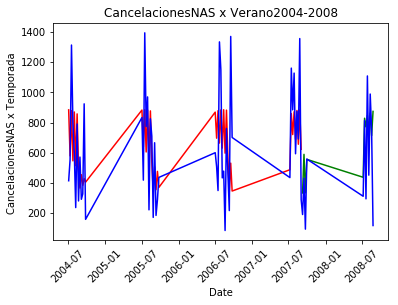

IndexDates
2004-07-04   2004-07-04
2004-07-11   2004-07-11
2004-07-18   2004-07-18
2004-07-25   2004-07-25
2004-08-01   2004-08-01
2004-08-08   2004-08-08
2004-08-15   2004-08-15
2004-08-22   2004-08-22
2004-08-29   2004-08-29
2004-09-05   2004-09-05
2004-09-12   2004-09-12
2004-09-19   2004-09-19
2004-09-26   2004-09-26
2005-07-03   2005-07-03
2005-07-10   2005-07-10
2005-07-17   2005-07-17
2005-07-24   2005-07-24
2005-07-31   2005-07-31
2005-08-07   2005-08-07
2005-08-14   2005-08-14
2005-08-21   2005-08-21
2005-08-28   2005-08-28
2005-09-04   2005-09-04
2005-09-11   2005-09-11
2005-09-18   2005-09-18
2005-09-25   2005-09-25
2006-07-02   2006-07-02
2006-07-09   2006-07-09
2006-07-16   2006-07-16
2006-07-23   2006-07-23
2006-07-30   2006-07-30
2006-08-06   2006-08-06
2006-08-13   2006-08-13
2006-08-20   2006-08-20
2006-08-27   2006-08-27
2006-09-03   2006-09-03
2006-09-10   2006-09-10
2006-09-17   2006-09-17
2006-09-24   2006-09-24
2007-07-08   2007-07-08
2007-07-15   2007-07-15
2007-

In [83]:
df = pd.read_csv('CancellationCodexSemana2004-2008.csv')
df.Date = pd.to_datetime(df.Date)
df = df[((df.Date.dt.month >= 7) & (df.Date.dt.month <=9 ))]
#df['Date'] = df.Date[((df.Date.dt.month >= 7) & (df.Date.dt.month <=9 ))]
df['Delay'] = df['Cancelled_C']
df = outliers_cuartil(df)
df = df[0:5*12] #3 Temporadas 
fig, ax= plt.subplots()

ECM = predecir(4*12, 'fusion')
#df.set_index('Date')
print("Error de predicción: {:.2f}".format(ECM))

# add the x-axis ad the y-axis to the plot
ax.plot(df['Date'], 
        df['Delay'], 
        color = 'blue')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="CancelacionesNAS x Temporada ",
       title="CancelacionesNAS x Verano2004-2008");
plt.savefig("images/CancellationxVeranoNAS2004-2008.png")
plt.show()
print(df['Date'])

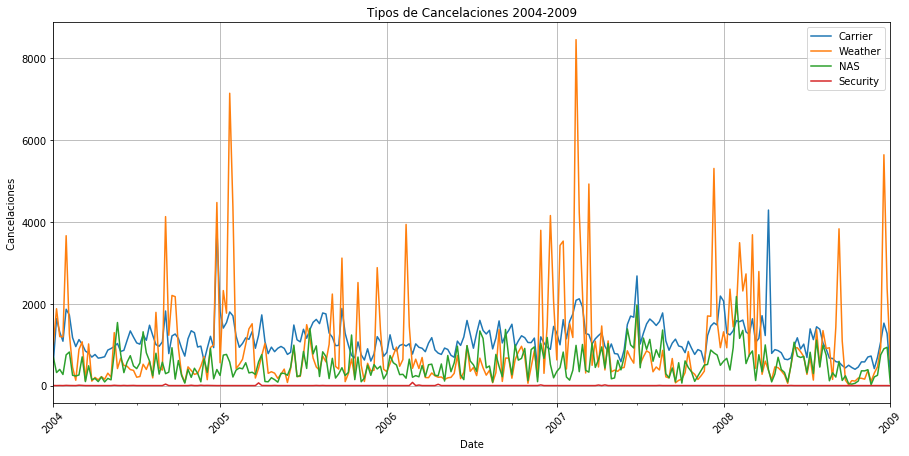

In [7]:
df = pd.read_csv('CancellationCodexSemana2004-2008.csv',parse_dates = ['Date'],index_col = ['Date'])
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
df.columns = ['Carrier', 'Weather', 'NAS', 'Security']
ax.set(xlabel="CancelacionesxSemanas 2004-2009",
       ylabel=" Cancelaciones ",
       title="Tipos de Cancelaciones 2004-2009")
df.plot(ax=ax)
plt.grid(True)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.savefig("images/CancelacionesCausasxWeek2004-2008.png")

,Date,Carrier,Weather,NAS,Security,sum
0,2004-01-31,4594.0,5264.0,1680.0,4.0,11542.0
1,2004-02-29,6834.0,6384.0,2314.0,18.0,15550.0
2,2004-03-31,3341.0,2312.0,1425.0,4.0,7082.0
3,2004-04-30,2816.0,713.0,571.0,2.0,4102.0
4,2004-05-31,4587.0,2884.0,3407.0,9.0,10887.0
5,2004-06-30,4481.0,1726.0,2097.0,10.0,8314.0
6,2004-07-31,4397.0,1340.0,3082.0,1.0,8820.0
7,2004-08-31,5727.0,3385.0,2476.0,2.0,11590.0
8,2004-09-30,5074.0,9727.0,1700.0,38.0,16539.0
9,2004-10-31,5265.0,2101.0,1514.0,10.0,8890.0


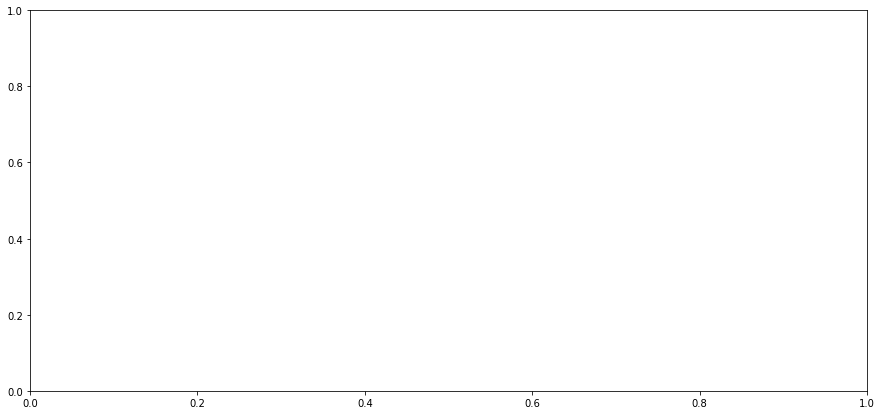

In [34]:

df = pd.read_csv('CancellationCodexMes2004-2008.csv')
#df =df.drop(columns ='Cancelled_B')
df['sum'] = df.sum(axis=1)
fig, ax = plt.subplots(figsize=(15,7))
df.columns = ['Date','Carrier','Weather' ,'NAS', 'Security', 'sum']
df
#df.plot(ax=ax)

Hacemos drop de weather para el sin clima

0 1.5900000000000012 21476.94150005536
Error de predicción: 31378081.95


/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


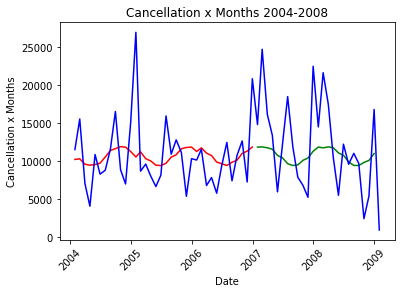

In [37]:
fig, ax= plt.subplots()
df['Delay'] = df['sum']
ECM = predecir(12*3, 'fusion')
#df.set_index('Date')
print("Error de predicción: {:.2f}".format(ECM))

# add the x-axis ad the y-axis to the plot
ax.plot(df.index.values, 
        df['sum'], 
        color = 'blue')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Cancellation x Months",
       title="Cancellation x Months 2004-2008");
plt.savefig("images/CancelacionesxMeses2004-2008ConClimaFusion.png",bbox_inches = "tight" )

1 1.5200000000000011 1282.3452206597199
Error de predicción: 87445.70


/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


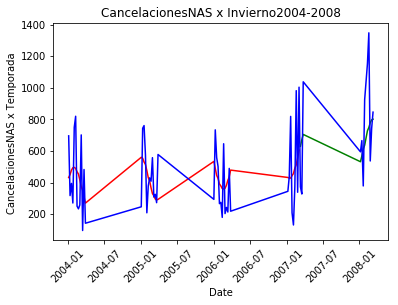

IndexDates
2004-01-04   2004-01-04
2004-01-11   2004-01-11
2004-01-18   2004-01-18
2004-01-25   2004-01-25
2004-02-01   2004-02-01
2004-02-08   2004-02-08
2004-02-15   2004-02-15
2004-02-22   2004-02-22
2004-02-29   2004-02-29
2004-03-07   2004-03-07
2004-03-14   2004-03-14
2004-03-21   2004-03-21
2004-03-28   2004-03-28
2005-01-02   2005-01-02
2005-01-09   2005-01-09
2005-01-16   2005-01-16
2005-01-23   2005-01-23
2005-01-30   2005-01-30
2005-02-06   2005-02-06
2005-02-13   2005-02-13
2005-02-20   2005-02-20
2005-02-27   2005-02-27
2005-03-06   2005-03-06
2005-03-13   2005-03-13
2005-03-20   2005-03-20
2005-03-27   2005-03-27
2006-01-01   2006-01-01
2006-01-08   2006-01-08
2006-01-15   2006-01-15
2006-01-22   2006-01-22
2006-01-29   2006-01-29
2006-02-05   2006-02-05
2006-02-12   2006-02-12
2006-02-19   2006-02-19
2006-02-26   2006-02-26
2006-03-05   2006-03-05
2006-03-12   2006-03-12
2006-03-19   2006-03-19
2006-03-26   2006-03-26
2007-01-07   2007-01-07
2007-01-14   2007-01-14
2007-

In [87]:
df = pd.read_csv('CancellationCodexSemana2004-2008.csv')
df.Date = pd.to_datetime(df.Date)
df = df[((df.Date.dt.month >= 1) & (df.Date.dt.month <=3 ))]
#df['Date'] = df.Date[((df.Date.dt.month >= 7) & (df.Date.dt.month <=9 ))]
df['Delay'] = df['Cancelled_C']
df = outliers_cuartil(df)
df = df[0:5*12] #3 Temporadas 
fig, ax= plt.subplots()

ECM = predecir(4*12, 'fusion')
#df.set_index('Date')
print("Error de predicción: {:.2f}".format(ECM))

# add the x-axis ad the y-axis to the plot
ax.plot(df['Date'], 
        df['Delay'], 
        color = 'blue')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="CancelacionesNAS x Temporada ",
       title="CancelacionesNAS x Invierno2004-2008");
plt.savefig("images/CancelInviernoNAS2004-2008.png")
plt.show()
print(df['Date'])

In [ ]:
Cancelaciones por meses

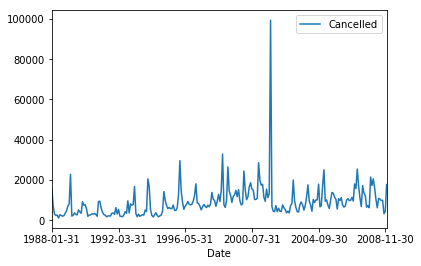

In [93]:
df = pd.read_csv('CancellationxMonths1988-2008.csv')
df.index = df.Date
plt.setp(ax.get_xticklabels(), rotation=45)
df.plot()

In [104]:
# Graficos los datos reales para tenerlos como referencia

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion,familia):
    #yolo
    particiones = 5
    if familia != 'fusion':
        regr = linearregression.CuadradosMinimos(familia)
        df_entrenamiento = df[df.index.isin(rango_entrenamiento)]    
        xi =df_entrenamiento.index.values.astype(float)
        # 'Fiteo' los datos de entrenamiento
        grado = 0
        min_rmse = cross_validation(df,'Date','Cancelled',particiones,familia,grado)
        mejor_grado = 0
        if familia == 'pol':
            while grado <= 20:
                rmse = cross_validation(df,'Date','Cancelled',particiones,familia,grado)
                grado += 1
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado
            print(mejor_grado, min_rmse)
        else:
            while grado < 2:
                rmse = cross_validation(df,'Date','Cancelled',particiones,familia,grado*math.pi)
                grado += 0.01                
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado*math.pi
            print(mejor_grado/math.pi, min_rmse)
        regr.fit(mejor_grado,xi, df_entrenamiento['Cancelled'])
        df_entrenamiento['pred'] = regr.predict(xi)
        ax.plot(df_entrenamiento.index.values, df_entrenamiento['pred'],'r-')
        ## Realizo predicciones
        df_prediccion = df[df.index.isin(rango_prediccion)]
        xs = df_prediccion.index.values.astype(float)
        # Predigo los datos de testeo
        df_prediccion['pred'] = regr.predict(xs)
        # Grafico la prediccion
        ax.plot(df_prediccion.index.values, df_prediccion['pred'], 'g-')

        ## Calculo el Error Cuadrático Mediodf_prediccion['y'
        ECM = ((df_prediccion['pred'] - df_prediccion['Cancelled'])**2).mean()    
        return ECM
    else:
        regr = linearregression.CuadradosMinimos(familia)
        df_entrenamiento = df[df.index.isin(rango_entrenamiento)]    
        xi =df_entrenamiento.index.values.astype(float)
        # 'Fiteo' los datos de entrenamiento
        grado = 0
        pi = 0
        min_rmse = cross_validation_fusion(df,'Date','Cancelled',particiones,familia,grado,pi*math.pi)
        mejor_grado = 0
        mejor_pi = 0
        while grado <= 20:
            pi = 0
            while pi < 2:
                rmse = cross_validation_fusion(df,'Date','Cancelled',particiones,familia,grado,pi*math.pi)
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado
                    mejor_pi = pi
                pi += 0.01
            grado +=1
        print(mejor_grado,mejor_pi/math.pi, min_rmse)
        regr.fit_fusion(mejor_grado,mejor_pi*math.pi,xi, df_entrenamiento['Cancelled'])
        df_entrenamiento['pred'] = regr.predict(xi)
        ax.plot(df_entrenamiento.index.values, df_entrenamiento['pred'],'r-')
        ## Realizo predicciones
        df_prediccion = df[df.index.isin(rango_prediccion)]
        xs = df_prediccion.index.values.astype(float)
        # Predigo los datos de testeo
        df_prediccion['pred'] = regr.predict(xs)
        # Grafico la prediccion
        ax.plot(df_prediccion.index.values, df_prediccion['pred'], 'g-')

        ## Calculo el Error Cuadrático Mediodf_prediccion['y'
        ECM = ((df_prediccion['pred'] - df_prediccion['Cancelled'])**2).mean()    
        return ECM
        

def predecir(k,familia):
    rango_entrenamiento =(df.index[0:k] )    
    rango_prediccion = (df.index[k:k+(12*2)] )
    return entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion,familia)

1 0.5856901905781753 21864.620910513244
Error de predicción: 11395325.53


/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


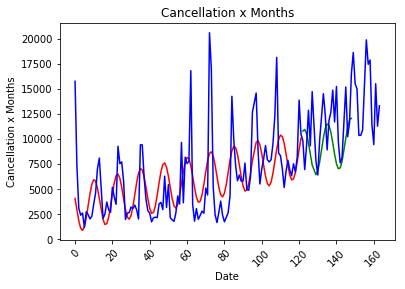

In [105]:
df = pd.read_csv('CancellationxMonths1988-2008.csv')
df['Delay'] = df['Cancelled']
df = df[(df['Date'] < '2001-09-11')]
df = outliers_cuartil(df)
fig, ax= plt.subplots()
ECM = predecir(12*10, 'fusion')
#df.set_index('Date')
print("Error de predicción: {:.2f}".format(ECM))

# add the x-axis and the y-axis to the plot
ax.plot(df.index.values, 
        df['Cancelled'], 
        color = 'blue')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Cancellation x Months",
       title="Cancellation x Months");
plt.savefig("CancellationxMonths1988-2008PredFusion1.png")
plt.show()

In [ ]:
Nota: Lo cambiamos para ver el otro